# Linear model - Global Feature Effects

Hold on! Why to explain a linear model, isn't it explainably by design?
Well, there is some debate on that, but, for the sake of this tutorial, let's assume it really is.
So, this is exactly why se selected it; we want to have an intuition of what "_the ideal feature effect would look like_" while demonstrating the various feature effect methods of the `Effector` package.

In [1]:
import numpy as np
import effector

## Generate a toy dataset

We will generate $N=1000$ examples with 3 features each. The features are defined as follows:

- $x_1$: a linearly spaced feature between $0$ and $1$, i.e., $x_1 \sim \mathcal{U}(0,1)$
- $x_2$: a normally distributed feature with mean $x_1$ and standard deviation of $0.01$, i.e., $x_2 \sim \mathcal{N}(x_1, 0.01)$
- $x_3$: a normally distributed feature with mean $0$ and standard deviation of $1$, i.e., $x_3 \sim \mathcal{N}(0, 1)$


In [2]:
def generate_dataset(N, x1_min, x1_max, x2_sigma, x3_sigma):
    x1 = np.concatenate((np.array([x1_min]),
                         np.random.uniform(x1_min, x1_max, size=int(N - 2)),
                         np.array([x1_max])))
    x2 = np.random.normal(loc=x1, scale=x2_sigma)
    x3 = np.random.normal(loc=np.zeros_like(x1), scale=x3_sigma)
    return np.stack((x1, x2, x3), axis=-1)


In [3]:
np.random.seed(21)

N = 1000
x1_min = 0
x1_max = 1
x2_sigma = .01
x3_sigma = 1.

X = generate_dataset(N, x1_min, x1_max, x2_sigma, x3_sigma)

## Define the model

As mentioned above, we will use a linear model to demonstrate the various feature effect methods:

$$
y = 7x_1 - 3x_2 + 4x_3
$$

In linear models, it is trivial to compute the ground-truth effect of each feature. The effect of $x_i$ is simply $\alpha_i x_i$, so the effect of $x_1$ is $7x_1$, of $x_2$ is $-3x_2$, and of $x_3$ is $4x_3$.
Beacuse some methods require the gradient of the model, we will define it as well.

In [4]:
def predict(x):
    y = 7*x[:, 0] - 3*x[:, 1] + 4*x[:, 2]
    return y

def predict_grad(x):
    df_dx1 = 7 * np.ones([x.shape[0]])
    df_dx2 = -3 * np.ones([x.shape[0]])
    df_dx3 = 4 * np.ones([x.shape[0]])
    return np.stack([df_dx1, df_dx2, df_dx3], axis=-1)

---
## Feature Effect methods

Feature effect methods explain the black-box model by estimating the effect of each feature on the model's prediction.

Let's introduce some basic notation, we will denote: 

* $f(x): \mathbb{R}^D \rightarrow \mathbb{R}$, the model's prediction as where $\mathbb{x}$ is the input to the model.
* $x_s$ the feature(s) of interest, i.e., the feature(s) we want to explain. In the simplest case, $x_s$ is a single feature, but it can also be a set of features.
* $x_c$ the remaining features, i.e., $\mathbb{x} = (x_s, x_c)$. 
* $f(x_s, x_c): \mathbb{R}^S \times \mathbb{R}^C \rightarrow \mathbb{R}$, the model's prediction where $x_s$ is the set of features of interest and $x_c$ is the set of features that are not of interest.

In the following sections, we will demonstrate the various feature effect methods contained within the `Effector` package:

* Partial Dependence Plot (PDP) and Individual Conditional Expectation (ICE)
* Accumulated Local Effect (ALE) and its variants, like RHALE

---
## Partial Dependence Plot (PDP)

The PDP is defined as the average of the model's prediction over the entire dataset, while varying the feature of interest.

PDP is defined as 

$$ \text{PDP}(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] $$ 

and is approximated by 

$$\hat{\text{PDP}}(x_s) = \frac{1}{N} \sum_{j=1}^N f(x_s, x^{(i)}_c)$$

On a linear model, the PDP is simply the effect of the feature of interest plus a constant: $\text{PDP}(x_s) = \alpha_s x_s + c$.
Let's check it out using `effector`.

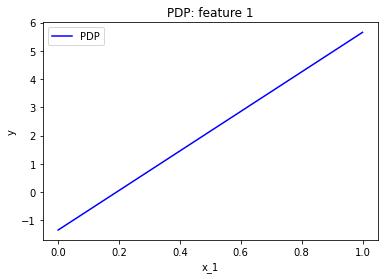

In [5]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0)

### Centering issues

The effect estimated by PDP is a line with gradient 7, which confirms with the ground truth. 
However, there is an issue with the constant $c$. In the plot above, the line is approximately $7x_1 - 1.5$ so $c \approx - 1.5$.  
This happens because with the default behaviour:

$$PDP(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] = a_sx_s + \sum_{j \neq s} a_j \mathbb{E}_{x_j}[x_j] = a_sx_s - 3 * 0.5 + 4 * 0 = a_sx_s - 1.5$$
 
`Effector` offers three alternatives ways to center any feature effect plot, using the `centering` parameter. 
The first one is the one examined above, i.e. using `centering=False` which is the default. The other two alternatives are:

Setting `centering=True` or `centering="zero-integral"`, where the PDP is centered around the $y$ axis (equal mass below and above the $y$ axis):

$$c = \mathbb{E}_{x_s \sim \mathcal{U(0,1)}}[PDP(x_s)] = \mathbb{E}_{x_s \sim \mathcal{U(0,1)}}[a_sx_s] = 7*0.5 = 3.5$$ 


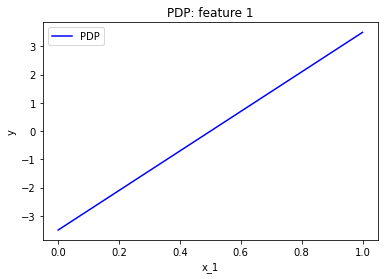

In [6]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering=True)

The second one is setting `centering="zero-start"`, where the PDP starts at $y=0$, i.e. $c=0$. 

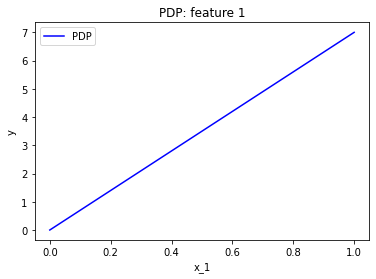

In [7]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering="zero_start")

### Heterogeneity or Uncertainty in PDP

Global feature effect methods visualize the average effect of a specific feature on the output.
The averaging is done over the instance-level effects. It is therefore crucial to know to what extent 
the underlying local (instance-level) effects deviate from the average effect.  

In PDP plots there are two ways to check that, either plotting the ICE plots or plotting the standard deviation of the instance level effects as $\pm$ interval around the PDP plot. 

#### ICE plots

ICE plots are the instance-level effects of the feature of interest; on ICE plot can be defined per instance using the following formula:

$$\text{ICE}^{(i)}(x_s, x^{(i)}_c) = f(x_s, x^{(i)}_c)$$

ICE are plotted on-top of the PDP plot. Then, the user can visually observe how the instance-level effects deviate from the average effect.
For example in the plot below, we can see that there so no heterogeneity in the instance-level effects, i.e., all instance-level effects are lines with gradient 7.
However, be careful that this is more obvious using the argument `centering=True` or `centering="zero-integral"`.
Otherwise the instance-level effects are not centered around the $y$ axis and may create the illusion of heterogeneity, although if you take a closer look, you will see that all instance-level effects are lines with gradient 7.

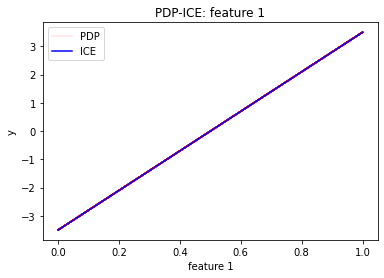

In [8]:
fig, ax = effector.PDPwithICE(data=X, model=predict).plot(feature=0, centering=True)

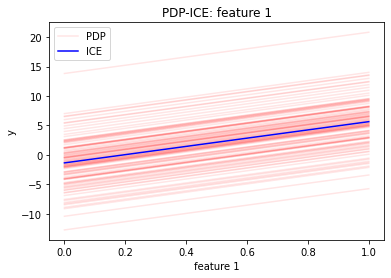

In [9]:
fig, ax = effector.PDPwithICE(data=X, model=predict).plot(feature=0, centering=False)

The second way to check for heterogeneity is by plotting the standard deviation of the instance-level effects as $\pm$ interval around the PDP plot.
This is done by setting `plot_std=True` in the `plot` method.
However, as we will see, this can be tricky. The standard deviation of the instance-level effects is computed without centering the PDP plot, i.e., the PDP plot is not subtracted from the instance-level effects and by showing only standard deviation of the residuals, we may get the illusion of heterogeneity.
Previously, in the uncentered version of the ICE plots we encountered this issue. However, since ICE plots show the **type** of the heterogeneity, we could easily spot that the heterogeneity was 
only in the intercept and not in the gradient of the instance-level effects. Unfortunately, this is not the case with the standard deviation of the residuals, which in this case lead to a misleading interpretation. This is why we recommend using the centered version of the ICE plots.


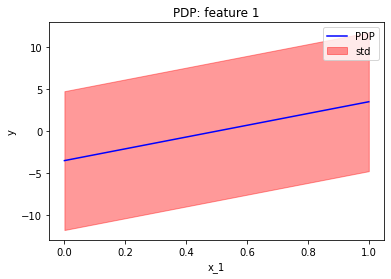

In [10]:

fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering=True, confidence_interval="std")


# Derivative-PDP (d-PDP)

There same analysis can be done based on the derivative of the model and its name is Derivative-PDP (d-PDP).
The d-PDP is defined as the average of the derivative of the model's prediction over the entire dataset, while varying the feature of interest.

$$ \text{d-PDP}(x_s) = \mathbb{E}_{x_c}[\frac{\partial f}{\partial x_s} (x_s, x_c)] $$

We have to mention that:
 
* d-PDP needs the model's gradient, which is not always available.
* Under normal circumstances, the d-PDP should not be centered because the absolute value of the derivative has a meaning for the interpretation.
* The interpretation of the d-PDP effect is different, since it is given in the gradient-space. In d-PDP the effect of the feature of interest says how much the model's prediction changes when the feature of interest changes. This is different from PDP, where the effect of the feature of interest says how much the specific feature contributes to the prediction. 

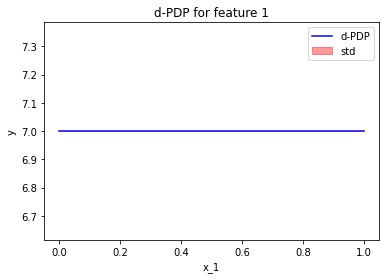

In [11]:
fig, ax = effector.DerivativePDP(data=X, model=predict, model_jac=predict_grad).plot(feature=0, confidence_interval=True)

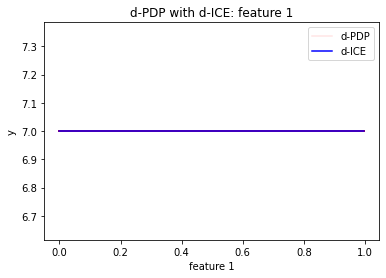

In [12]:
fig, ax = effector.DerivativePDPwithICE(data=X, model=predict, model_jac=predict_grad).plot(feature=0)

# Accumulated Local Effects

Accumulated Local Effects (ALE) is the second big class of feature effect methods.
Before we delve into the details, let's see how the ALE plot looks like.

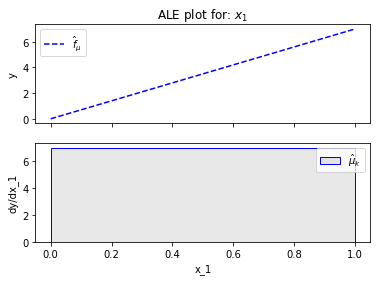

In [13]:
effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0)

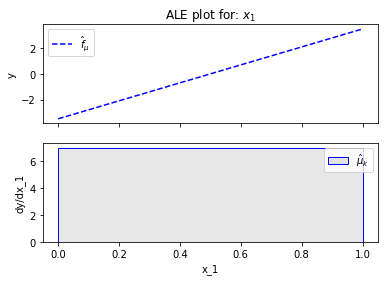

In [14]:
effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0, centering=True)

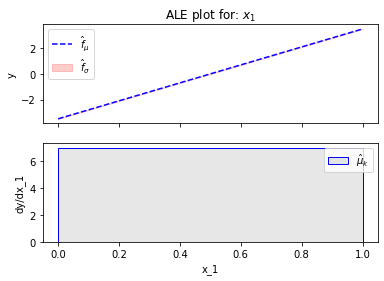

In [15]:
effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0, centering=True, confidence_interval="std")
